In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import xgboost as xgb
import os

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesClassifier
from sklearn.svm import SVR
from scipy.stats import randint, uniform
import xgboost


In [3]:
data_model = pd.read_csv("model/data_model.csv")

## Process weather data

In [4]:
weather_data = pd.read_csv("data/weather_data_leuven.csv")

In [5]:
import re
## rename the column
weather_data.columns = [re.sub(' \(.*\)', "", col) for col in weather_data.columns]

In [8]:
# extract from timestamp
weather_data["time"] = pd.to_datetime(weather_data['time'])
weather_data['date'] = weather_data['time'].dt.date
weather_data['hour'] = weather_data['time'].dt.hour
weather_data["month"] = weather_data["time"].dt.month
weather_data['weekday'] = weather_data['time'].dt.strftime('%a')

In [9]:
weather_data = weather_data.groupby(["date", "hour", "month", "weekday"]).mean().reset_index()

C:\Users\svnel\AppData\Local\Temp\ipykernel_35440\2866054732.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weather_data = weather_data.groupby(["date", "hour", "month", "weekday"]).mean().reset_index()


## Process airquality data



In [11]:
air_quality_data = pd.read_csv("data/air_quality_full.csv")

In [14]:
# Dropping index csv column
air_quality_data.drop(['Unnamed: 0'], inplace = True, axis  = 1)

In [15]:
# extract from timestamp
air_quality_data["dt"] = pd.to_datetime(air_quality_data['dt'])
air_quality_data['date'] = air_quality_data['dt'].dt.date
air_quality_data['hour'] = air_quality_data['dt'].dt.hour
air_quality_data["month"] = air_quality_data["dt"].dt.month
air_quality_data['weekday'] = air_quality_data['dt'].dt.strftime('%a')

In [16]:
air_quality_data = air_quality_data.groupby(["date", "hour", "month", "weekday"]).mean().reset_index()

C:\Users\svnel\AppData\Local\Temp\ipykernel_35440\4239833663.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  air_quality_data = air_quality_data.groupby(["date", "hour", "month", "weekday"]).mean().reset_index()


## Processing traffic leuven data (Currently not used, could delete this)

In [64]:
traffic_data = pd.read_csv("/content/drive/MyDrive/MDA_TIEN/traffic_leuven_2022.csv")

In [65]:
traffic_data.head(5)

,instance_id,segment_id,date,interval,uptime,heavy,car,bike,pedestrian,heavy_lft,...,bike_lft,bike_rgt,pedestrian_lft,pedestrian_rgt,direction,car_speed_hist_0to70plus,car_speed_hist_0to120plus,timezone,v85,location
0,-1,9000000627,2022-01-01T00:00:00.000Z,hourly,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Brussels,NaN,redingenhof
1,-1,9000000627,2022-01-01T01:00:00.000Z,hourly,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Brussels,NaN,redingenhof
2,-1,9000000627,2022-01-01T02:00:00.000Z,hourly,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Brussels,NaN,redingenhof
3,-1,9000000627,2022-01-01T03:00:00.000Z,hourly,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Brussels,NaN,redingenhof
4,-1,9000000627,2022-01-01T04:00:00.000Z,hourly,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Europe/Brussels,NaN,redingenhof


In [67]:
np.unique(traffic_data.segment_id)

array([    347365,     347690,     347860,     347931,     347948,
           349054, 9000000627, 9000000672, 9000000674, 9000000681,
       9000000764, 9000000773, 9000001547])

In [68]:
traffic_data.columns

Index(['instance_id', 'segment_id', 'date', 'interval', 'uptime', 'heavy',
       'car', 'bike', 'pedestrian', 'heavy_lft', 'heavy_rgt', 'car_lft',
       'car_rgt', 'bike_lft', 'bike_rgt', 'pedestrian_lft', 'pedestrian_rgt',
       'direction', 'car_speed_hist_0to70plus', 'car_speed_hist_0to120plus',
       'timezone', 'v85', 'location'],
      dtype='object')

In [69]:
np.unique(traffic_data.location)

array(['BROUWERSSTRAAT', 'Bierbeekstraat', 'Bondgenotenlaan',
       'Dekenstraat', 'Fonteinstraat 137 b 301',
       'Jan Pieter Minckelersstraat', 'Kapucijnenvoer',
       'Petermannenstraat', 'Pleinstraat', 'Ridderstraat', 'Tiensestraat',
       'Vital Decostersstraat', 'redingenhof'], dtype=object)

## Processing file 40 data, merge all files

In [18]:
def merge_csv_files(directory_path):
    """
    Merges all CSV files in a directory into a single pandas DataFrame.
    
    Args:
    directory_path (str): The directory path containing the CSV files.
    
    Returns:
    merged_df (pandas.DataFrame): The merged pandas DataFrame of all CSV files in the directory.
    """
    dfs = []

    # loop through each file in the directory
    for file in os.listdir(directory_path):
        # check if the file is a CSV file
        if file.endswith('.csv'):
            file_path = os.path.join(directory_path, file)
            if directory_path.endswith("dataverse_file"):
                df = pd.read_csv(file_path, delimiter=",")
            else:
                df = pd.read_csv(file_path, delimiter=";")
            dfs.append(df)

    # concatenate all dataframes 
    merged_df = pd.concat(dfs, ignore_index=True)

    return merged_df


In [19]:
# Noise data
file40 = merge_csv_files('data/file_40')

In [21]:
### we would delete unit column because of same values
# drop all _unit columns
cols_to_drop  = [col for col in file40.columns if col.endswith('unit')]
file40.drop(cols_to_drop, axis=1, inplace=True)

# rename columns
file40.rename(columns={'description':'location',
                       "#object_id": "object_id"}, inplace=True)

In [23]:
# Convert the 'result_timestamp' column to a datetime data type
file40['result_timestamp'] = pd.to_datetime(file40['result_timestamp'])
file40['date'] = file40['result_timestamp'].dt.date
file40['hour'] = file40['result_timestamp'].dt.hour
file40["month"] = file40["result_timestamp"].dt.month
file40['weekday'] = file40['result_timestamp'].dt.strftime('%a')

In [24]:
file40 = file40.groupby(["object_id", "date", "hour", "month", "weekday"]).mean().reset_index()

C:\Users\svnel\AppData\Local\Temp\ipykernel_35440\918127979.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  file40 = file40.groupby(["object_id", "date", "hour", "month", "weekday"]).mean().reset_index()


In [25]:
data_model_v2 = file40.merge(air_quality_data, how = "inner",
                          left_on = ["date", "hour", "month", "weekday"],
                          right_on = ["date", "hour", "month", "weekday"])

In [27]:
data_model_v2 = data_model_v2.merge(weather_data, how = "inner",
                          left_on = ["date", "hour", "month", "weekday"],
                          right_on = ["date", "hour", "month", "weekday"])

In [29]:
## split train, test data
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(data_model_v2, test_size=0.2, random_state = 7)

## Process independent variable

In [31]:
target_variable = [col for col in train_df.columns if col.startswith("laf")]
target_variable

['laf005_per_hour',
 'laf01_per_hour',
 'laf05_per_hour',
 'laf10_per_hour',
 'laf25_per_hour',
 'laf50_per_hour',
 'laf75_per_hour',
 'laf90_per_hour',
 'laf95_per_hour',
 'laf98_per_hour',
 'laf99_per_hour',
 'laf995_per_hour']

In [32]:
y_train = train_df[target_variable]

In [33]:
y_val = val_df[target_variable]

In [34]:
X_train = train_df.drop(target_variable + ["date"], axis = 1)
X_val = val_df.drop(target_variable + ["date"], axis = 1)

In [35]:
X_train.columns

Index(['object_id', 'hour', 'month', 'weekday', 'pm2_5', 'pm10', 'co', 'no2',
       'o3', 'so2', 'nh3', 'temperature_2m', 'relativehumidity_2m',
       'dewpoint_2m', 'apparent_temperature', 'pressure_msl',
       'surface_pressure', 'precipitation', 'rain', 'snowfall', 'weathercode',
       'cloudcover', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high',
       'shortwave_radiation', 'direct_radiation', 'diffuse_radiation',
       'direct_normal_irradiance', 'windspeed_10m', 'winddirection_10m',
       'windgusts_10m'],
      dtype='object')

In [36]:
one_hot_var = ["hour", "month", "weekday", "object_id"]
numerical_var = [col for col in X_train.columns if col not in one_hot_var]

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
t = ColumnTransformer(
    transformers = [
        ('OneHot', OneHotEncoder(handle_unknown='ignore'), one_hot_var),
        ('StandardScaler', StandardScaler(), numerical_var)
        
    ])

# fit the encoder
t.fit(X_train, y_train)


ColumnTransformer(transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['hour', 'month', 'weekday', 'object_id']),
                                ('StandardScaler', StandardScaler(),
                                 ['pm2_5', 'pm10', 'co', 'no2', 'o3', 'so2',
                                  'nh3', 'temperature_2m',
                                  'relativehumidity_2m', 'dewpoint_2m',
                                  'apparent_temperature', 'pressure_msl',
                                  'surface_pressure', 'precipitation', 'rain',
                                  'snowfall', 'weathercode', 'cloudcover',
                                  'cloudcover_low', 'cloudcover_mid',
                                  'cloudcover_high', 'shortwave_radiation',
                                  'direct_radiation', 'diffuse_radiation',
                                  'direct_normal_irradiance', 'windspeed_10m',
  

In [38]:
# create pandas DataFrame from dense matrix
X_train = pd.DataFrame(t.fit_transform(X_train), columns=t.get_feature_names_out())
X_val = pd.DataFrame(t.transform(X_val), columns=t.get_feature_names_out())

In [39]:
X_train.head(4)

,OneHot__hour_0,OneHot__hour_1,OneHot__hour_2,OneHot__hour_3,OneHot__hour_4,OneHot__hour_5,OneHot__hour_6,OneHot__hour_7,OneHot__hour_8,OneHot__hour_9,...,StandardScaler__cloudcover_low,StandardScaler__cloudcover_mid,StandardScaler__cloudcover_high,StandardScaler__shortwave_radiation,StandardScaler__direct_radiation,StandardScaler__diffuse_radiation,StandardScaler__direct_normal_irradiance,StandardScaler__windspeed_10m,StandardScaler__winddirection_10m,StandardScaler__windgusts_10m
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.798634,1.483143,-0.532452,0.443850,0.412554,0.396622,0.374955,-0.104376,-0.252202,0.404983
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.571274,-0.866924,1.171127,-0.677493,-0.565108,-0.742893,-0.677795,-0.422201,0.987511,-0.750655
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.144974,-0.640412,-1.012333,-0.677493,-0.565108,-0.742893,-0.677795,-0.898939,1.239656,-1.063640
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.258654,0.407209,0.499293,-0.677493,-0.565108,-0.742893,-0.677795,1.866138,0.147028,1.648898


## Predict laf50

In [117]:
# Define the model parameters
model_params = {
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'max_depth': randint(3, 50),
            'max_features': ['auto', 'sqrt'],
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'bootstrap': [True, False]
        }
    },
    'gradient_boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'learning_rate': uniform(0.01, 0.5),
            'max_depth': randint(1, 10),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10)
        }
    },
    
    'xgboost': {
        'model': xgboost.XGBRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'learning_rate': uniform(0.01, 0.5),
            'max_depth': randint(1, 10),
            'min_child_weight': randint(1, 10),
            'gamma': uniform(0, 1),
            'reg_alpha': uniform(0, 1),
            'reg_lambda': uniform(0, 1),
        }
    }
    
}

params_dict = {}

# Loop through each model in model_params and run RandomizedSearchCV
for model_name, model_info in model_params.items():
    print("Running RandomizedSearchCV for {}...".format(model_name))
    
    # Create a RandomizedSearchCV object for the current model
    model = model_info['model']
    param_dist = model_info['params']
    random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                       n_iter=10, cv=5, n_jobs=1, random_state=7)
    
    # Fit the RandomizedSearchCV object to the data
    random_search.fit(X_train, y_train["laf50_per_hour"])
    
    # Print the best parameters and score
    params_dict[model_name] = random_search.best_params_
    print("Best parameters for {}: ".format(model_name), random_search.best_params_)
    print("Best score for {}: ".format(model_name), random_search.best_score_)
    print("\n")

    '''
    Best parameters for random_forest:  {'bootstrap': False, 'max_depth': 47, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 18, 'n_estimators': 50}
Best score for random_forest:  0.5792830881635223


Running RandomizedSearchCV for gradient_boosting...
Best parameters for gradient_boosting:  {'learning_rate': 0.1442194900509356, 'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 98}
Best score for gradient_boosting:  0.5916298430632786


Running RandomizedSearchCV for xgboost...
Best parameters for xgboost:  {'gamma': 0.482636902412518, 'learning_rate': 0.3168517348631646, 'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 60, 'reg_alpha': 0.27651470778821396, 'reg_lambda': 0.44650589502340177}
Best score for xgboost:  0.5838444802560675
'''

Running RandomizedSearchCV for random_forest...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Best parameters for random_forest:  {'bootstrap': False, 'max_depth': 47, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 18, 'n_estimators': 50}
Best score for random_forest:  0.5792830881635223


Running RandomizedSearchCV for gradient_boosting...
Best parameters for gradient_boosting:  {'learning_rate': 0.1442194900509356, 'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 98}
Best score for gradient_boosting:  0.5916298430632786


Running RandomizedSearchCV for xgboost...
Best parameters for xgboost:  {'gamma': 0.482636902412518, 'learning_rate': 0.3168517348631646, 'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 60, 'reg_alpha': 0.27651470778821396, 'reg_lambda': 0.44650589502340177}
Best score for xgboost:  0.5838444802560675




In [132]:
from sklearn.metrics import mean_absolute_error
gb_params = params_dict['gradient_boosting']

gb = GradientBoostingRegressor(**gb_params, random_state=7)

gb.fit(X_train, y_train["laf50_per_hour"])

train_preds = gb.predict(X_train)
val_preds = gb.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["laf50_per_hour"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["laf50_per_hour"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["laf50_per_hour"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["laf50_per_hour"]))


Train RMSE: 2.029762747060196
Val RMSE: 2.5844144574670533
Train MAE: 1.3767856291596634
Val MAE: 1.7252515489883133


In [133]:
rf_params = params_dict['random_forest']

rf = RandomForestRegressor(**rf_params, random_state=7)

rf.fit(X_train, y_train["laf50_per_hour"])

train_preds = rf.predict(X_train)
val_preds = rf.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["laf50_per_hour"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["laf50_per_hour"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["laf50_per_hour"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["laf50_per_hour"]))

Train RMSE: 2.1817806108171154
Val RMSE: 2.8540405616733486
Train MAE: 1.43833149366866
Val MAE: 1.9009492637359475


In [134]:
import xgboost

xgb_params = params_dict['xgboost']

xgb = xgboost.XGBRegressor(**xgb_params, random_state=7)

xgb.fit(X_train, y_train["laf50_per_hour"])

train_preds = xgb.predict(X_train)
val_preds = xgb.predict(X_val)


print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["laf50_per_hour"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["laf50_per_hour"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["laf50_per_hour"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["laf50_per_hour"]))

Train RMSE: 1.9051655961122524
Val RMSE: 2.515229920798295
Train MAE: 1.308194844030876
Val MAE: 1.6795345072292627


Text(0, 0.5, 'y val')

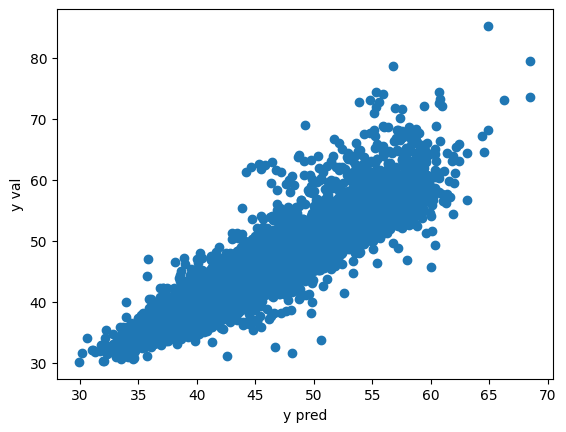

In [135]:
plt.scatter(val_preds, y_val["laf50_per_hour"])
plt.xlabel('y pred')
plt.ylabel('y val')

In [136]:
r2_score(val_preds, y_val["laf50_per_hour"])

0.8208224813819596

<BarContainer object of 30 artists>

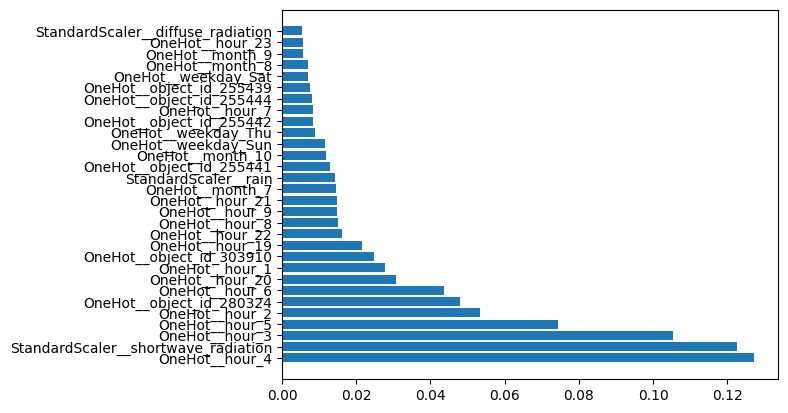

In [137]:
feature_importances = xgb.feature_importances_
sorted_idx = feature_importances.argsort()[::-1]
sorted_importances = feature_importances[sorted_idx[0:30]]
sorted_columns = list(X_train.columns[sorted_idx[0:30]])
plt.barh(sorted_columns, sorted_importances)